# {<[(BRACKETS)]>}

The purpose of this toy project is to investigate how different model architectures deal with a simple classification task. We will be building classification models to predict whether a sequence of bracket symbols is "gramatically" correct. 

### Rules

We define the grammar in the following way:
- All bracket symbols are grouped into pairs, with one opening and one closing, eg: ```()```, ```[]```, ```{}```, ```<>```.
- Every bracket opened should be closed. No closing bracket can exist if its corresponding opening hasn't come earlier. Eg ```(())```, ```[()]```, ```({})``` are correct; ```)(```, ```{}}```, ```{{{}``` are not.
- Brackets are opened and closed in a last in-first out manner, ie any closing bracket must correspond to the most recent yet unclosed opening one. Eg ```[{({})}]()``` is correct, ```[(])``` isn't.

These rules can be applied to a sequence of any length. Obviously, all correct sequences have an even number of characters. Since we want our models to be able to learn rules applicable to sequences of any length, we should make some adjustments in terms of sequence representation. Since some models will require a constant input length (eg a vanilla NN), we introduce a padding symbol. If a sequence is shorter than the maximum lenght (a hyperparameter), it will be padded by adding the necessary number of padding elements (here ```.```) at the end. This necessitates a couple additional grmmar rules:
- The padding elements at the end of a sequence are ignored, and the input is corect if the brackets are correct. Eg ```{}[]....``` is correct because it is the same as ```{}[]```; ```{[]}))...``` is not because ```{[]}))``` isn't
- Sequences in which the padding symbol comes before or inbetween any brackets are considered incorrect. Eg ```{[(...)]}...```, ```[]..()...``` are incorrect even if the brackets themselves are OK. A sequence consisting only of padding and no brackets (```......```) is also considered incorrect.

### The elephant in the room

It has likely already occured to the reader that the task described above can be easily achieved with explicit programming. A simple algorithm can very quickly tell us whether a sequence is correct with 100% accuracy and without the need for training an ML model. Normally, ML is applied to problems where explicit programming does not perform well enough - this is evidently not the case here. 

However, the simplicity of the task has some advantages. Firstly we can quickly and easily generate and label with 100% accuracy an arbitrarily large (subject to combinatorial constrains) datatset. Secondly, as the classification rules are explicit, complete, and relatively simple, we have a better chance of judging whether our models have learned them the way a human would, or are processing the sequences in another way entirely (we should however note the inherent problems with the interpetability of NNs). Lastly, the nature of the classification task implies that all bias is avoidable - that is, training a model to be 100% accurate is not inherently impossible.

That said, I should state that the purposes of this project are purely pedagogical and exploratory.

## APPROACH

We will be building a series of ML model with increasing complexity and comparing their performance. We will start with "vanilla" neural networks (NNs), comparing width vs depth, then move on to convolutional NNs, and finally try out more elaborate sequence models such as GRUs, LSTMs, and transformers.

We will be using PyTorch for handling data and buidling/training the models.

In [321]:
# Importing necessary packages

import random
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# Setting random seeds for reproducibility

torch.manual_seed(42)
random.seed(42)

In [327]:
# Utility functions

def IsValid(seq, match = {'(':')', '[':']', '{':'}', '<':'>'}, 
            pad = '.') -> bool:
    """
    Given an input sequence, return whether it is correct.
    """
    stack = []
    for idx, char in enumerate(seq):
        if char in match.keys():
            stack.append(char)
        elif char in match.values():
            if len(stack) == 0:
                return False
            if char == match[stack[-1]]:
                stack.pop()
                continue
            else:
                return False
        else:
            return (idx > 0 and 
                    all(i == pad for i in seq[idx:]) and 
                    len(stack) == 0)
    return len(stack) == 0

def SampleCorrect(n, match = {'(':')', '[':']', '{':'}', '<':'>'}, 
                  pad = '.', MAX_LEN = 10) -> set:
    """
    Create a set of gramatically correct sequences. Works faster than purely random generation.
    """
    res = set()
    while len(res) < n:
        stack = []
        pool = list(match.keys()) + [pad]
        newstr = ""
        while len(newstr) < MAX_LEN:
            if len(stack) == 0:
                toadd = random.choices(pool, k=1)[0]
            else:
                toadd = random.choices(pool + [match[stack[-1]]], k=1)[0]
            if toadd in match.keys():
                stack.append(toadd)
            elif toadd in match.values():
                stack.pop()
            elif toadd == pad:
                newstr += pad*(MAX_LEN - len(newstr))
                break
            newstr += toadd
        if IsValid(newstr):
            res.add(newstr)
    return res

def RealLen(seqs, pad = '.', 
            MAX_LEN = 10) -> list:
    """
    For dataset investigation purposes. 
    Gives the real lenghts (ie without end padding) of 
    a list of sequences as a list of ints.
    """
    lens = []
    for seq in seqs:
        for idx, char in enumerate(reversed(seq)):
            if not (char == pad):
                lens.append(MAX_LEN - idx)
                break
            if idx == MAX_LEN - 1:
                lens.append(0)
                break
    return lens

def count_parameters(model) -> int: 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def performance(outs, groundt, threshold = 0.5) -> dict:
    truepos, trueneg, falseneg, falsepos = 0., 0., 0., 0.
    preds = [int(out.item() >= threshold) for out in outs.view(-1)]
    for i in range(len(preds)):
        if preds[i] == 1 and int(groundt[i].item()) == 1:
            truepos += 1
        elif preds[i] == 1 and int(groundt[i].item()) == 0:
            falsepos += 1
        elif preds[i] == 0 and int(groundt[i].item()) == 0:
            trueneg += 1
        elif preds[i] == 0 and int(groundt[i].item()) == 1:
            falseneg += 1

    try:
        precision = truepos/(truepos + falsepos)
    except:
        precision = 0
    try:
        recall = truepos/(truepos + falseneg)
    except:
        recall = 0
    accuracy = (truepos+trueneg)/len(preds)
    try:
        Fscore = 2*precision*recall/(precision+recall)
    except:
        Fscore = 0
    perf = {"falsepos": falsepos,
            "falseneg": falseneg,
            "accuracy": round(accuracy, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "Fscore": round(Fscore, 4),
            }
    return perf

def ReadDataset(filename):
    seqs=[]
    with open(filename, 'r') as file:
        while True:
            seq = file.readline()
            if not seq:
                break
            seqs.append(seq.strip())
    labels = [int(IsValid(seq)) for seq in seqs]
    return seqs, labels


## The dataset

The dataset we'll be using for this exercise has been created in a separate notebook (```create.ipynb```). Here, we will import it and take a closer look at its features before processing it appropriately for our needs. We can familiarise ourselves with the dataset by getting its lengh, the number of positive examples, and taking a look at some of its elements.


In [3]:
Dataset, Labels = ReadDataset("dataset1.txt")
print(f'We have read a dataset of {len(Dataset)} sequences, {sum(Labels)} of which are correct.')
# Visualising the first 20 elements of the dataset
for i in range(20):
    print(f"{Dataset[i]} --> {Labels[i]}")

We have read a dataset of 20089 sequences, 10000 of which are correct.
<{<()([>.. --> 0
(>}(>]]{]> --> 0
<>{(){}}.. --> 1
]]){>[]]{. --> 0
{<<>>{}}<> --> 1
{}({})<>{} --> 1
(())[]{<>} --> 1
[}<])><>)[ --> 0
{()<><>}.. --> 1
([<><>]).. --> 1
<<[]><>>{} --> 1
{}{(<()>)} --> 1
(<(}>.()>( --> 0
{<><<>>}() --> 1
<[{][>]{}. --> 0
<()()><<>> --> 1
>}]({]<>>< --> 0
({}({}[])) --> 1
(<>[])(()) --> 1
(()<>}>[>[ --> 0


It is worth exploring and analysing the dataset before we go on to train models on it. For example, we are interested in how the positive examples are spread throughout it. Looking at the graph bellow, we can see the number of correct examples per 100 follows a reasonably normal distribution centred around 50, which is consistent with positive examples constituting just under 50% of the dataset.

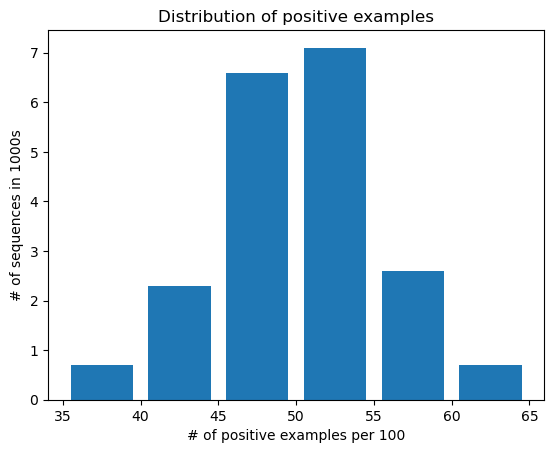

In [9]:
plt.hist([sum(Labels[100*i:100*(i+1)]) for i in range(200)], bins = [35, 40, 45, 50, 55, 60, 65], rwidth=0.8);
plt.title('Distribution of positive examples');
plt.xlabel('# of positive examples per 100');
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], [0, 1, 2, 3, 4, 5, 6, 7])
plt.ylabel('# of sequences in 1000s');

The lengths of the sequences - that is, how many characters occur before the _final_ padding - is also of interest. In particular, we'd like to know if there is a difference in distributions in that aspect between the correct and incorrect examples. Note that our utility function ```RealLen()``` counts padding symbols in the middle of the sequence towards it's length, i.e. ```(){[]}.().``` is considered length 9.

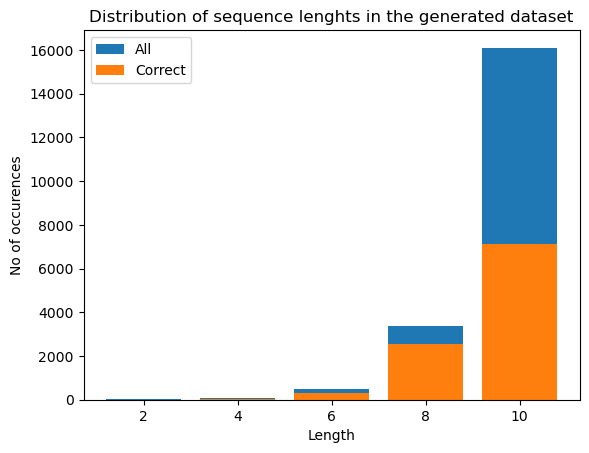

In [10]:
plt.hist(RealLen(Dataset), bins = [1, 3, 5, 7, 9, 11], rwidth=0.8, label='All');
plt.hist(RealLen([i for i in Dataset if IsValid(i)]), bins = [1, 3, 5, 7, 9, 11], rwidth=0.8, label='Correct');
plt.title('Distribution of sequence lenghts in the generated dataset');
plt.xlabel('Length');
plt.ylabel('No of occurences');
# plt.yscale('log');
plt.legend();

We can judge from the graphs above that correct sequences seem to be somewhat over-represented at lengths 4 - 8 (toggling the log-scale on and off helps see this). This can be explained by the way we have generated the dataset, and by the combinatorics of the problem in geeral. It is good to be aware of this apparent bias in our dataset, and observe closely if it results in a "missunderstanding" in the training (for example, a model could learn to associate a large number of padding symbols at the end with a high probability of the sequence being correct, instead of learning the rule that padding symbols at the end are irrelevant). 

### Processing the Dataset 

As of now, we have a list of strings and a list of integer labels (1 and 0) for them. To make our dataset compatible with the ML framework that we will be using - PyTorch - we need to change these into the ```torch.tensor``` datatype. This is particualrly important for the carrying out of back propagation _via_ the highly efficient implentation of _auto grad_, which allows for the computation of the local derivatives for all trainable parameters at each epoch.

During the data processing, we also need to turn our strings of characters into arrays of numbers - so called encoding. Due to the logical and discrete (as opposed to continuous and scalar) nature of the input sequences, we will be using one-hot encoding. Each symbol is encoded as a vector of length ```dict_size``` (9 in our default case) comprised of zeros and  single 1, meaning all sequences will now be represented as vectors of length ```MAX_LEN*dict_size``` (90 by default).

In [322]:
# Creating the encoding dicts
MAX_LEN = 10
chars = {'(', ')', '[', ']', '{', '}', '<', '>', '.'}
dict_size = len(chars)
stoi, itos = {}, {}
for idx, char in enumerate(sorted(list(chars))):
    stoi[char] = idx
    itos[idx] = char

# One-hot encoding the dataset
dict_enc = torch.tensor([[stoi[char] for char in seq] for seq in Dataset])
enc = F.one_hot(dict_enc, num_classes=dict_size).to(torch.float32).reshape(len(Dataset), dict_size*MAX_LEN)

# Creating a decoding function
decoder_vector = torch.tensor([stoi[char] 
                    for char in sorted(list(chars))]).reshape(dict_size, 1)
def decode(encoded):
    """
    Decode a one-hot encoding back into a string.
    inp: encoded torch.tensor of shape (1, MAX_LEN*dict_size)
    out: str of len MAX_LEN
    """
    return ''.join([itos[i.item()] 
                    for i in (encoded.view(MAX_LEN, dict_size).to(torch.int64) @ decoder_vector).view(-1)])

# Cecking what we've done
print(f"The encoded input has shape {enc.shape}.\n"
      f"The sequence {Dataset[0]} is one-hot encoded as follows:\n{enc[0]},\n"
      f"and then decoded as {decode(enc[0])}")


The encoded input has shape torch.Size([20089, 90]).
The sequence <{<()([>.. is one-hot encoded as follows:
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
and then decoded as <{<()([>..


### Splitting into train/dev/test

Additionally, we would like to split our dataset into 3 subsets:
- Training, which we will be using to train the model,
- Development (a.k.a. cross-validation), which we will use to tune hyperparameters and get a sense of the generalisation/overfitting, and finally
- Test, which we will use for an unbiased estimate of our model's performance.

We will be using a 80/10/10 split, which is a common choice for datasets of modest size like ours.

In [5]:
# Splitting into train/dev/test
n1 = int(len(Dataset)*0.8)
n2 = int(len(Dataset)*0.9)

with torch.no_grad():
    Xtr = enc[0:n1]
    Xdev = enc[n1:n2]
    Xte = enc[n2:]
    Ytr = torch.tensor(Labels[0:n1], dtype=torch.float32).reshape(-1, 1)
    Ydev = torch.tensor(Labels[n1:n2], dtype=torch.float32).reshape(-1, 1)
    Yte = torch.tensor(Labels[n2:], dtype=torch.float32).reshape(-1, 1)

train_size = Xtr.shape[0]
Xtr.shape

torch.Size([16071, 90])

It is useful to ensure we have split the dataset in a reasonable way. One easy check we can do is to see if the correct examples have been distributed somewhat evenly. Keeping in mind the Train set is 8 times bigger than the Dev and Test, this distribution of correct examples is reasonable.

Note it is important that the Dev and Test sets come from the same distribution, as we use the former to tune our model, and the latter to determine how well we have tuned it. Changing the train dataset by e.g. adding some amount of randomly generated sequences wouldn't be as much of a problem. For the time being, let is stick with this dataset.

In [6]:
print(f'Number of correct examples in Train: {int(torch.sum(Ytr).item())}')
print(f'Number of correct examples in Dev: {int(torch.sum(Ydev).item())}')
print(f'Number of correct examples in Test: {int(torch.sum(Yte).item())}')

Number of correct examples in Train: 7992
Number of correct examples in Dev: 987
Number of correct examples in Test: 1021


### Variance and bias

As said above, we will be using the train set to train the model, and the development set to tune hyperparameters. As the model never "sees" the data points from the dev set, it is bound to do more poorly on them. Sometimes, the disparity between the model's performance on the test and dev sets is deemed significant, and in these case the model is said to be overfitting to the training data. We call such models __high-variance__, as their performance varies significantly with the change of dataset. High-variance models generally suffer from an inability to generalise to data they haven't been trained on. This is sometimes referred to as a __generalisation gap__.

In somewhat of an oppoisition of varience exists __bias__, which roughly speaking is a measure of the overall performance of the model. A model with a high train loss but a low difference between train and dev is said to be a high-bias model - it generalises well but does overall poorly. 

In many cases there is a trade-off between reducing bias and variance. It is usually the case that large and more complex models tend to overfit to the training data (high variance), whereas smaller and more naive models fail to learn an approrpiately complex function and therefore yield poor predictions(high bias). Different __regularisation__ techniques have been developed to allow for a reduction in variance, notably punishing the model for learning large weights, and introducing dropout layers. These techniques usually end up preventing the model from learning a good function and increase bias.

Notably, a model could be simultaneously high-bias and high-variance - this would be considered a very bad model.

### Mini-batch gradient descent

When working with reasonably sized datasets, ML practitioners tend not to perform forward propagation using the whole dataset during triaining. The main reason is that this approach is computationally too expensive, as it necessitates the NN to perform an imense amount of computation. Instead, datapoints are passed in the form of (randomly sampled) mini-batches, i.e. subsets of the dataset. This means every forward pass is performed on a smaller and more manageable chunk of data, which allows for a larger number of epochs to be carrid out for the same amount of time. For numerical efficiency reasons, mini-batch sizes are usually chosen as powers of 2, and usually range between 32 and 512. The choice of mini-batch size is not a trivial matter and depends on the size of the dataset and the nature of the task. It is one of the hyperparameters we will be varying for this project.

Because of the noise (randomness) mini-batch gradient descent introduces in the training, it tends to have a regularizing effect (prevents overfitting), as the model never sees the whole train set simultaneously. This also affects the way the minimizer function is searched for, and allows for a slower and more stable optimisation which is less likely to be stuck at a local minimum (see more [here](https://arxiv.org/abs/1609.04836)).

## Model A - shallow neural network

We begin our exploration of model architectures by considering a simple NN, consiting of one Dense layer with ReLU activation, feeding into a single neuron which then uses a sigmoid non-linearity to give a classification prediction in the [0, 1] range. We will be verying the number of neurons in the first layer, and the batch sizes used during training, to see how that affects performance.

For convenience, we define our own NN class for each type of architecture, which is built upon the PyTorch Sequential API but also incorporates some utility functions. 


In [323]:
class Shallow:
    def __init__(self, units = 8, 
                 Xtrain = Xtr, Ytrain = Ytr, Xdevel = Xdev, Ydevel = Ydev, 
                 verb = True):
        self.train_losses, self.dev_losses = [], []
        self.best_score, self.best_epoch = 0, 0
        self.best = None

        self.model = nn.Sequential(
                nn.Linear(MAX_LEN*dict_size, units),
                nn.ReLU(),
                nn.Linear(units, 1),
                nn.Sigmoid()
                )
        with torch.no_grad():
            self.Xtrain = Xtrain
            self.Ytrain = Ytrain
            self.Xdevel = Xdevel
            self.Ydevel = Ydevel
            self.train_size = Xtrain.shape[0]
            self.num_param = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        if verb:
            print(f"Creating a model with {self.num_param} trainable parameters.")

    def __call__(self, X):
        self.out = self.model(X)
        return self.out

    def train(self, num_epochs = 5000, batch_size = 128, log_freq = 100):
        """
        Performing the requested number of optimisation steps with the 
        appropriate batch size. A record of the train and dev losses is
        bkept at specified intervals, and the model with the best
        F-score is saved for future inference.
        """
        self.model.train = True
        for epoch in range(num_epochs):
            batch_idxs = random.sample(range(self.train_size), batch_size)
            outs = self.model(self.Xtrain[batch_idxs])
            loss = F.binary_cross_entropy(outs, self.Ytrain[batch_idxs])
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % log_freq == 0:
                self.train_losses.append(loss.item())
                with torch.no_grad():
                    dev_pred = self.model(self.Xdevel)
                    dev_loss = F.binary_cross_entropy(dev_pred, self.Ydevel)
                    self.dev_losses.append(dev_loss.item())
                if performance(self.model(self.Xdevel), self.Ydevel)["Fscore"] > self.best_score:
                    self.best_score = performance(self.model(self.Xdevel), self.Ydevel)["Fscore"]
                    self.best = deepcopy(self.model)
                    self.best_epoch = epoch
        
    def plot(self, after = 0):
        """
        Plots a simple graph of the train and dev losses with 
        training. Used to judge the performance of the model:
        bias and variance.
        """
        print(f"Best performance at epoch {self.best_epoch}")
        plt.plot(self.train_losses[after:], label = 'train')
        plt.plot(self.dev_losses[after:], label = 'dev')
        plt.title('Training and validation losses during learning')
        plt.xlabel('Epochs')
        plt.ylabel('Binary cross-entropy loss')
        plt.legend()

    def print_mislabeled(self, from_train = True, from_dev = True, threshold = 0.5):
        if from_train:
            print("Mislabeled examples from training set:")
            train_pred = [int(out.item() >= threshold) for out in self.best(self.Xtrain)]
            for i in range(len(train_pred)):
                if not train_pred[i] == int(self.Ytrain[i].item()):
                    print(decode(self.Xtrain[i]))
        if from_dev:
            print("Mislabeled examples from development set:")
            dev_pred = [int(out.item() >= threshold) for out in self.best(self.Xdevel)]
            for i in range(len(dev_pred)):
                if not dev_pred[i] == int(self.Ydevel[i].item()):
                    print(decode(self.Xdevel[i]))


We now create a series of networks with 8 neurons in the first layer each, varying the size of the mini-batches used in training. We will be using our utility functions to monitor the behaviour and performance of the models.

Please note that due to the randomness in mini-batch selection, separate executions of the following cells will not result in identical results. It might be instructive/interesting to the reader to try re-initialising and training the models a few times each to gain a better understanding of the particular architecture's performance.

In [324]:
a1 = Shallow(units=8)

Creating a model with 737 trainable parameters.


In [325]:
a1.train(num_epochs=25000, batch_size=256)

### Evaluating the model

A good first step for gaining insight into how our model is doing is to look at the change in training and validation loss. The loss function is an indication of how far off the predictions made by the model are from the ground truth - if it is decreasing, then our model is learning, i.e. improving its predictions. 

Binary classification models produce two kinds of errors - false positives and false negatives. These give rise to precision and recall, which together give a better evaluation of the model than its accuracy alone. Since having a single evaluation metric has its benefits, these two quantities are usually combined into an F-score, which is the main metric we use here(see more [here](https://en.wikipedia.org/wiki/F-score)).

As the F-score is a better evaluator of the real predicitve possibilites of a model than its cross-entropy losses (see below), we use it to establish which epoch gave the best weights, and save that version of the model for further inference.

Best performance at epoch 23400
Performance on train set:  {'falsepos': 3.0, 'falseneg': 0.0, 'accuracy': 0.9998, 'precision': 0.9996, 'recall': 1.0, 'Fscore': 0.9998}
Performance on dev set:  {'falsepos': 6.0, 'falseneg': 0.0, 'accuracy': 0.997, 'precision': 0.994, 'recall': 1.0, 'Fscore': 0.997}


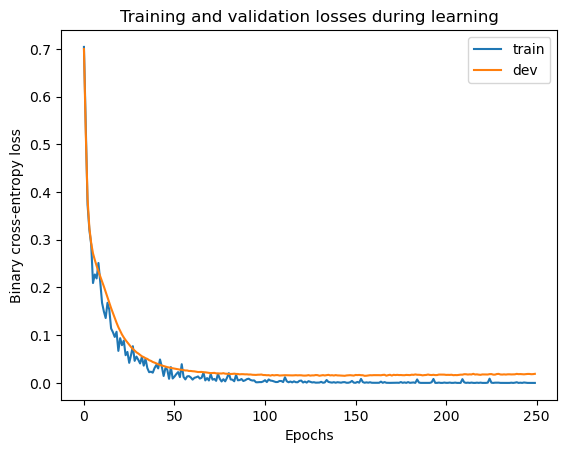

In [329]:
a1.plot()
print("Performance on train set: ", performance(a1.best(Xtr), Ytr))
print("Performance on dev set: ", performance(a1.best(Xdev), Ydev))

We should make an important note here concerning the difference between binary cross-entropy loss and predictive capability. On the one hand, we are aiming at a model which perfomrs binary classification - that is, it separates inputs into two distinct categories: correct and incorrect sequences. However, the output of the neural network is actually a continuous value provided by the last sigmoid layer. We can treat this value as a n estimate of the probability that a sequence is correct, and we usually apply a treshold (or decision boundary, by default 0.5) to make the classification. 

It is important, however, to keep in mind that during training, the model aims to minimise losses, that is the distances between the probability estimate and the ground truth. To give an illustration, probability outputs 0.6 and 0.9 would both be categorised as correct, but the former will have a greater associated loss. It follows that with the setup we have, it is impossible for the model to not overfit at all to the training set - taht is, there will always be a difference in the losses achieved on the train and validation sets. However, that does not necessarily trainslate to a generality gap in terms of the real predictive capability measured in false positives/negatives and the F-score. With this subtlety in mind, we will be taking a closer look at the perfomance of our models before we declare them high-variance.

It is sometimes instructive to take a look at the particular examples that our model mislabeled. Note these will vary with different runs.

In [330]:
a1.print_mislabeled()

Mislabeled examples from training set:
{{)]{>.>..
[(>[)>{<.>
{>><.(.}))
Mislabeled examples from development set:
([<}().>()
[[{>{}..>)
[({]<{.})>
{}>><<....
{[}{{}<}]}
{({>)](}[)


We notice that our model tends to produce more false positives than false negatives. This implies the overall performance as measured by F-score could be improved by increasing the decision boundary. Below we plot the performance with variyng classification treshold. Note that these will be higly variant at different runs. Nevertheless it is useful to keep in mind that the classification treshold is one of the hyperparameters of the model which could be tweaked in order to improve performance.

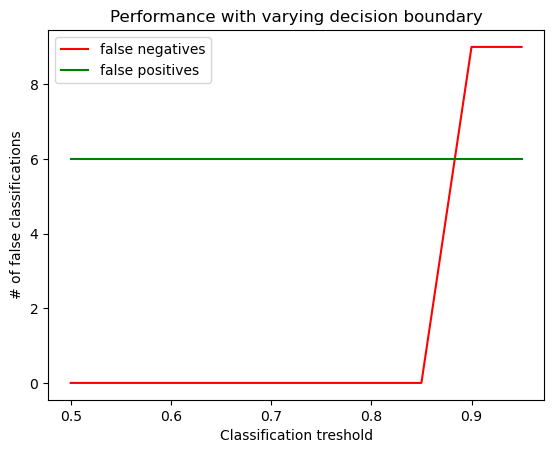

In [331]:
plt.plot([i/20. for i in range(10, 20)], 
        [performance(a1.best(Xdev), Ydev, threshold=i/20.)["falseneg"] for i in range(10, 20)], 
        color='red', label = 'false negatives')
plt.plot([i/20. for i in range(10, 20)], 
        [performance(a1.best(Xdev), Ydev, threshold=i/20.)["falsepos"] for i in range(10, 20)], 
        color='green', label = 'false positives')
plt.title("Performance with varying decision boundary")
plt.xlabel('Classification treshold')
plt.ylabel("# of false classifications")
plt.legend();

Overall, even this relatively simple model performs rather well on the classification task. We now go on to investigate the effect of the mini-batch size on the performance of the model. We will create a series of identical models and train them with varying mini-batch sizes. It might be necessary to allow for a greater number of epochs when using a smaller batch size.

Please note that due to the randomness of batch selection and weight initialisation, separate instances of nitialising+training each of the models below lead to different results. This happend despite my having initialised random seeds in the beginning of this notebook - I am unsure why.

In [335]:
a2 = Shallow(units=8)

Creating a model with 737 trainable parameters.


In [336]:
a2.train(num_epochs=40000, batch_size=128)

Best performance at epoch 18600
Performance on train set:
 {'falsepos': 3.0, 'falseneg': 0.0, 'accuracy': 0.9998, 'precision': 0.9996, 'recall': 1.0, 'Fscore': 0.9998}
Performance on dev set:
 {'falsepos': 5.0, 'falseneg': 0.0, 'accuracy': 0.9975, 'precision': 0.995, 'recall': 1.0, 'Fscore': 0.9975}
Mislabeled examples from training set:
<>[}{][]..
<)<{.>(<.>
[<<{{}.].]
Mislabeled examples from development set:
[({]<{.})>
{)[<>}]])}
<{)>......
<(][)[}(]>
{}>><<....


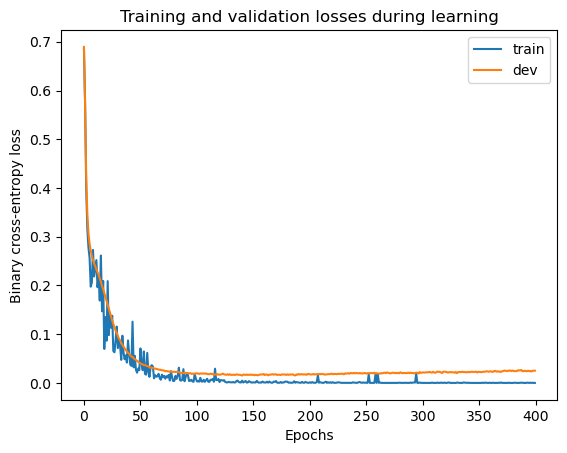

In [337]:
a2.plot()
print("Performance on train set:\n", performance(a2.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a2.best(Xdev), Ydev))
a2.print_mislabeled()

We notice the optimisation here is noisier due to the smaller batch size. Multiple executions of the procedure lead to rather disparate results, which can also likely be atribted to the randomness in the process.

As an aside, the sequence ```{}>><<....``` seems to pop up among the mislabeled ones quite often (at least for me). It would be correct had the < and > brackects been switched - perhaps the models manage to learn there is a relationship between these two symbols, but fail to distinguish opening from closing (just a speculation).

Going further with decreasing batch size:

Creating a model with 737 trainable parameters.
Best performance at epoch 12800
Performance on train set:
 {'falsepos': 5.0, 'falseneg': 0.0, 'accuracy': 0.9997, 'precision': 0.9994, 'recall': 1.0, 'Fscore': 0.9997}
Performance on dev set:
 {'falsepos': 3.0, 'falseneg': 0.0, 'accuracy': 0.9985, 'precision': 0.997, 'recall': 1.0, 'Fscore': 0.9985}
Mislabeled examples from training set:
<>[}{][]..
[<(><(()])
[<<{{}.].]
({{]()})[}
{){}]][<.}
Mislabeled examples from development set:
[({]<{.})>
{}>><<....
(<})]({}<>


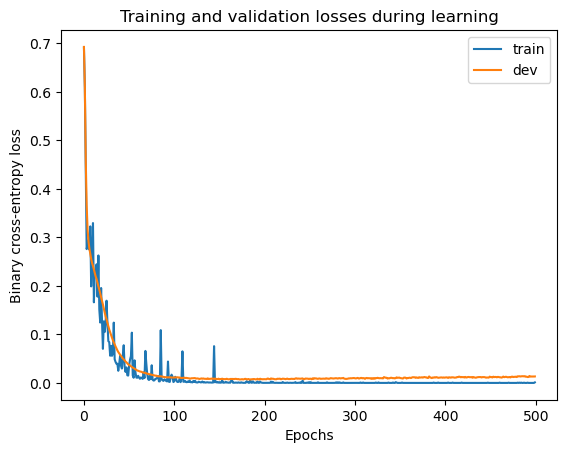

In [339]:
a3 = Shallow(units=8)
a3.train(num_epochs=50000, batch_size=64)
a3.plot()
print("Performance on train set:\n", performance(a3.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a3.best(Xdev), Ydev))
a3.print_mislabeled()

Creating a model with 737 trainable parameters.
Best performance at epoch 12100
Performance on train set:
 {'falsepos': 17.0, 'falseneg': 0.0, 'accuracy': 0.9989, 'precision': 0.9979, 'recall': 1.0, 'Fscore': 0.9989}
Performance on dev set:
 {'falsepos': 3.0, 'falseneg': 0.0, 'accuracy': 0.9985, 'precision': 0.997, 'recall': 1.0, 'Fscore': 0.9985}
Mislabeled examples from training set:
[<<>>})]{]
[><]<>)>>)
<>[}{][]..
([()}{>]])
<][{}}}][]
(<<(]]>..}
(><[][[]]]
<{{((>....
[<)(>{}]>)
((<{][[>)]
<{)({()>..
{>[{[]}}>]
<><{>)(>{]
{>><.(.}))
({{]()})[}
<>[(}<)]..
[}{>[]{})]
Mislabeled examples from development set:
[({]<{.})>
{}>><<....
[<><>{><{>


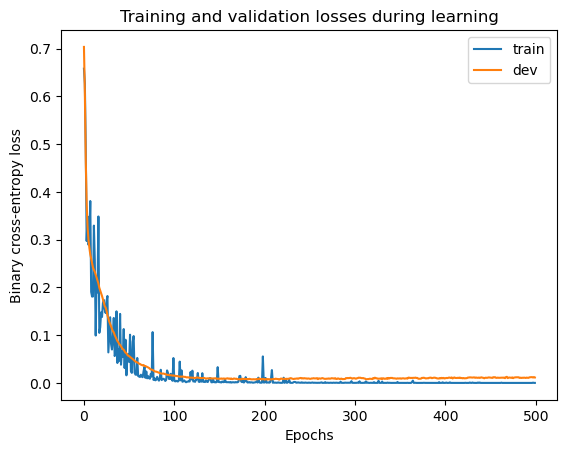

In [340]:
a4 = Shallow(units=8)
a4.train(num_epochs=50000, batch_size=32)
a4.plot()
print("Performance on train set:\n", performance(a4.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a4.best(Xdev), Ydev))
a4.print_mislabeled()

### Trying smaller models

Creating a model with 553 trainable parameters.
Best performance at epoch 23900
Performance on train set:
 {'falsepos': 4.0, 'falseneg': 0.0, 'accuracy': 0.9998, 'precision': 0.9995, 'recall': 1.0, 'Fscore': 0.9997}
Performance on dev set:
 {'falsepos': 6.0, 'falseneg': 0.0, 'accuracy': 0.997, 'precision': 0.994, 'recall': 1.0, 'Fscore': 0.997}
Mislabeled examples from training set:
{].){).{.)
()}][})>])
{<>())>].)
{[{(<(.}.]
Mislabeled examples from development set:
[({]<{.})>
{)[<>}]])}
[[(>}]<][}
[>)]<(}{}]
<{][[(..>>
{}>><<....


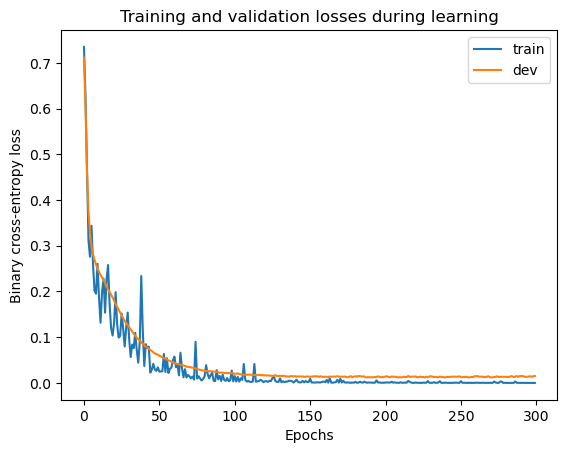

In [341]:
a5 = Shallow(units=6)
a5.train(num_epochs=30000, batch_size=64)
a5.plot()
print("Performance on train set:\n", performance(a5.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a5.best(Xdev), Ydev))
a5.print_mislabeled()

Creating a model with 553 trainable parameters.
Best performance at epoch 57900
Performance on train set:
 {'falsepos': 15.0, 'falseneg': 0.0, 'accuracy': 0.9991, 'precision': 0.9981, 'recall': 1.0, 'Fscore': 0.9991}
Performance on dev set:
 {'falsepos': 11.0, 'falseneg': 0.0, 'accuracy': 0.9945, 'precision': 0.989, 'recall': 1.0, 'Fscore': 0.9945}
Mislabeled examples from training set:
[])(>[]<}}
{]{>...}]}
[(>[)>{<.>
{<(>)).<.>
{{>(}>))}}
[){[>>>>.}
({>]}())]}
<[)<}>]..>
()>)>..}(>
()]{}><].}
{<<[[(.)(>
<<{]].)>}}
())]..>}>>
({.)}]{}.)
<}}>}}.>.>
Mislabeled examples from development set:
{<>>{}{[)>
<}}>].<>.}
([[{>()>>>
<{(}]<}}}>
{><})]{{>>
{{{[>}[>..
{<)({>.]<)
<{<>][{(.}
{<>))](<>>
(]})<>)>].
{))]}<{}.}


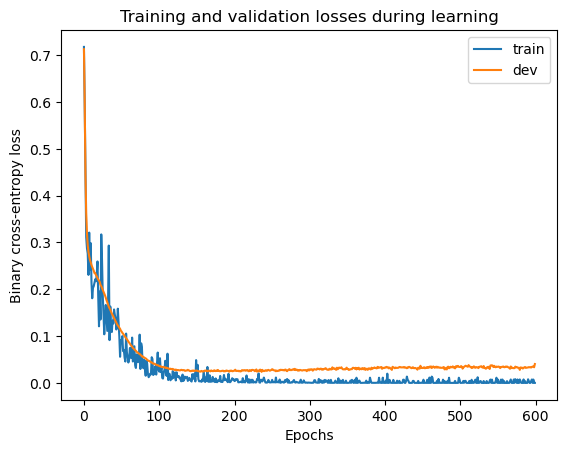

In [343]:
a6 = Shallow(units=6)
a6.train(num_epochs=60000, batch_size=128)
a6.plot()
print("Performance on train set:\n", performance(a6.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a6.best(Xdev), Ydev))
a6.print_mislabeled()

Creating a model with 553 trainable parameters.
Best performance at epoch 56700
Performance on train set:
 {'falsepos': 44.0, 'falseneg': 0.0, 'accuracy': 0.9973, 'precision': 0.9945, 'recall': 1.0, 'Fscore': 0.9973}
Performance on dev set:
 {'falsepos': 8.0, 'falseneg': 0.0, 'accuracy': 0.996, 'precision': 0.992, 'recall': 1.0, 'Fscore': 0.996}
Mislabeled examples from training set:
{){()}>()]
([{}({.)<]
{>)>}][)[)
[>}(])>[..
[)}([<{}}}
[(]>][]{]}
{[)[([})>>
<[>)((}[])
({[[)](>..
{[<<}]((}>
[}<)][....
[>[)))}<})
[{<>][<]]]
{}{}<}<){]
<>[}{][]..
<<}{[]>{>]
()])(>{}[>
{([])[>))]
{}({([<>>>
<[)))({}..
(<<]<)()])
<}>>{(<)(]
{<{>))}}..
[<<{{}.].]
{<(}[>(]..
[[<((}(>>)
([)[{)<)]}
{>>{[(>]]}
{{[}}]>[{}
{}}<>{]>[>
{<)<<>.][]
<({{<}}}..
<{]<<>(}..
(([}{}<>..
[(([<}(]..
<[<<>(][)]
({{]()})[}
[>)<](})..
([><[)}<]]
<><<>[))])
{))(}[>{}>
<)({]]][])
{{}<}]{<>}
()]}{([}..
Mislabeled examples from development set:
[({]<{.})>
{)>]{(]]]]
<>]{[[>]>)
<<{<{})>(}
{<>>]])>[)
<[))(>>...
(<})]({}<>
[(]))(]>})

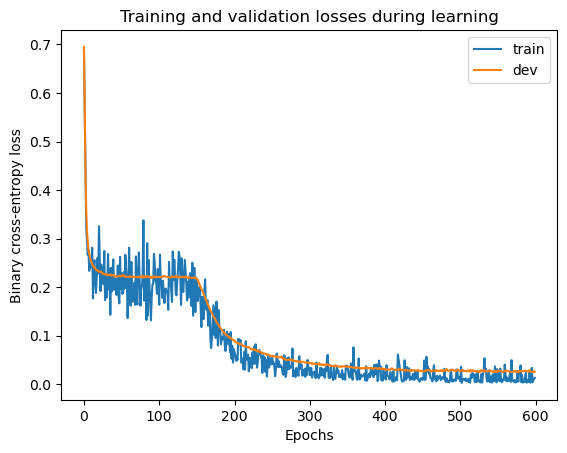

In [344]:
a7 = Shallow(units=6)
a7.train(num_epochs=60000, batch_size=256)
a7.plot()
print("Performance on train set:\n", performance(a7.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a7.best(Xdev), Ydev))
a7.print_mislabeled()

Let's push our luck and see what happens if we only use a measly 4 neurons in the first layer.

Creating a model with 369 trainable parameters.
Best performance at epoch 52500
Performance on train set:
 {'falsepos': 6.0, 'falseneg': 0.0, 'accuracy': 0.9996, 'precision': 0.9992, 'recall': 1.0, 'Fscore': 0.9996}
Performance on dev set:
 {'falsepos': 8.0, 'falseneg': 0.0, 'accuracy': 0.996, 'precision': 0.992, 'recall': 1.0, 'Fscore': 0.996}
Mislabeled examples from training set:
(({}})}(.)
<<(}).}..]
[}[<)>}{.}
<]]}(>.}.)
<)](>>}<.}
[(])}](}.}
Mislabeled examples from development set:
([<}().>()
<}}>].<>.}
[({]<{.})>
{{{[>}[>..
[[(>}]<][}
<(][)[}(]>
[{]..[)}.>
{}>><<....


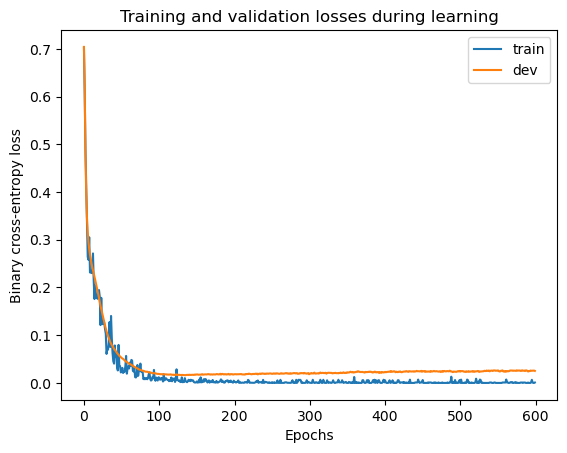

In [346]:
a8 = Shallow(units=4)
a8.train(num_epochs=60000, batch_size=256)
a8.plot()
print("Performance on train set:\n", performance(a8.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a8.best(Xdev), Ydev))
a8.print_mislabeled()

Creating a model with 185 trainable parameters.
Best performance at epoch 66200
Performance on train set:
 {'falsepos': 6.0, 'falseneg': 0.0, 'accuracy': 0.9996, 'precision': 0.9992, 'recall': 1.0, 'Fscore': 0.9996}
Performance on dev set:
 {'falsepos': 8.0, 'falseneg': 0.0, 'accuracy': 0.996, 'precision': 0.992, 'recall': 1.0, 'Fscore': 0.996}
Mislabeled examples from training set:
[<<<][.}.)
{<(>)).<.>
[]({[{<>}}
{{>(}>))}}
[}](><)]>.
<>[}{][]..
Mislabeled examples from development set:
([[{>()>>>
<<<(.]{}}>
[{[[[][][]
{><})]{{>>
[{[)>}))..
<((){[(]>.
<{[}[<[>}>
<{}{{{)]>.


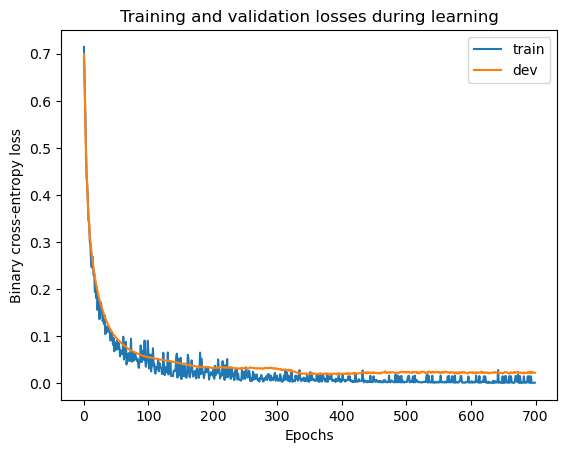

In [349]:
a9 = Shallow(units=2)
a9.train(num_epochs=70000, batch_size=512)
a9.plot()
print("Performance on train set:\n", performance(a9.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(a9.best(Xdev), Ydev))
a9.print_mislabeled()

Even these comically small architectures manage to produce reasonably good models with F-scores larger than 0.99! This is an indication of the simplicity of the classification task we have chosen.

However small, the models still use a somewhat substantial number of parameters. This can mainly be attributed to the large length of the input representation (```MAX_LEN*dict_size```) which is due to the one-hot encoding. It could be benefitial (and is certainly interesting to us here) to try models which circumvent that - either by allowing for complexity to be learned by depth rather than width of the NN, or by using sparse connections (convolutions). We investigate both options in due course.

## Model B - Deep(er) NNs

We create a new class for our "deep" networks which only differs from the shallow in the model architecture - it has 2 rather than one hidden layers. The second layer allows for a more sophisticated function to be learned without adding a great amount of learnable parameters. We should note however that deeping the network increases the computational cost of training and inference due to the larger compute graph.

In [350]:
class Deep:
    def __init__(self, units = (6, 2), 
                 Xtrain = Xtr, Ytrain = Ytr, Xdevel = Xdev, Ydevel = Ydev, 
                 verb = True, dp = 0):
        self.train_losses, self.dev_losses = [], []
        self.best_score, self.best_epoch = 0, 0
        self.best = None

        self.model = nn.Sequential(
                nn.Linear(MAX_LEN*dict_size, units[0]),
                nn.Dropout(p = dp),
                nn.ReLU(),
                nn.Linear(units[0], units[1]),
                nn.ReLU(),
                nn.Linear(units[1], 1),
                nn.Sigmoid()
                )
        with torch.no_grad():
            self.Xtrain = Xtrain
            self.Ytrain = Ytrain
            self.Xdevel = Xdevel
            self.Ydevel = Ydevel
            self.train_size = Xtrain.shape[0]
            self.num_param = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        if verb:
            print(f"Creating a model with {self.num_param} trainable parameters.")

    def __call__(self, X):
        self.out = self.model(self.Xtrain)
        return self.out

    def train(self, num_epochs = 5000, batch_size = 128, log_freq = 100):
        """
        Performing the requested number of optimisation steps with the 
        appropriate batch size. A record of the train and dev losses is
        bkept at specified intervals, and the model with the best
        F-score is saved for future inference.
        """
        self.model.train = True
        for epoch in range(num_epochs):
            batch_idxs = random.sample(range(self.train_size), batch_size)
            outs = self.model(self.Xtrain[batch_idxs])
            loss = F.binary_cross_entropy(outs, self.Ytrain[batch_idxs])
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % log_freq == 0:
                self.train_losses.append(loss.item())
                with torch.no_grad():
                    dev_pred = self.model(self.Xdevel)
                    dev_loss = F.binary_cross_entropy(dev_pred, self.Ydevel)
                    self.dev_losses.append(dev_loss.item())
                if performance(self.model(self.Xdevel), self.Ydevel)["Fscore"] > self.best_score:
                    self.best_score = performance(self.model(self.Xdevel), self.Ydevel)["Fscore"]
                    self.best = deepcopy(self.model)
                    self.best_epoch = epoch
        
    def plot(self, after = 0):
        """
        Plots a simple graph of the train and dev losses with 
        training. Used to judge the performance of the model:
        bias and variance.
        """
        print(f"Best performance at epoch {self.best_epoch}")
        plt.plot(self.train_losses[after:], label = 'train');
        plt.plot(self.dev_losses[after:], label = 'dev');
        plt.title('Training and validation losses during learning');
        plt.xlabel('Epochs (100s)');
        plt.ylabel('Binary cross-entropy loss');
        plt.legend();

    def print_mislabeled(self, from_train = True, from_dev = True, threshold = 0.5):
        if from_train:
            print("Mislabeled examples from training set:")
            train_pred = [int(out.item() >= threshold) for out in self.best(self.Xtrain)]
            for i in range(len(train_pred)):
                if not train_pred[i] == int(self.Ytrain[i].item()):
                    print(decode(self.Xtrain[i]))
        if from_dev:
            print("Mislabeled examples from development set:")
            dev_pred = [int(out.item() >= threshold) for out in self.best(self.Xdevel)]
            for i in range(len(dev_pred)):
                if not dev_pred[i] == int(self.Ydevel[i].item()):
                    print(decode(self.Xdevel[i]))


I have created and trained a few models to showcase the capabilities of this type of architecture. In terms of tweaking hyperparameters and layer sizes, the possibilites are endless - please feel free to change things up and try for yourself.

Please note that due to the randomness of batch selection and weight initialisation, separate executions of each of the cells below lead to different results. This happend despite my having initialised random seeds in the beginning of this notebook - I am unsure why.

Creating a model with 563 trainable parameters.
Best performance at epoch 7400
Performance on train set:
 {'falsepos': 6.0, 'falseneg': 0.0, 'accuracy': 0.9996, 'precision': 0.9992, 'recall': 1.0, 'Fscore': 0.9996}
Performance on dev set:
 {'falsepos': 0.0, 'falseneg': 0.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'Fscore': 1.0}


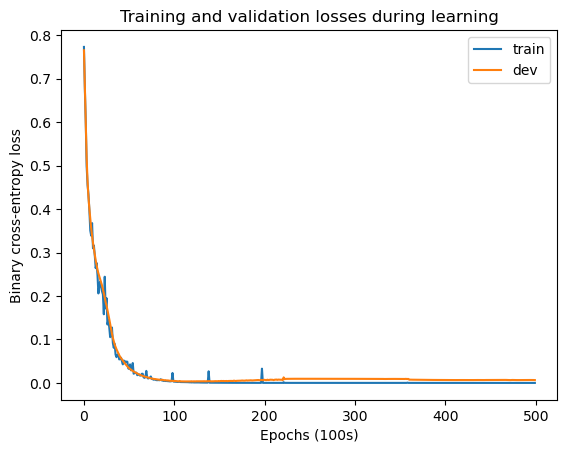

In [364]:
b1 = Deep(units = (6, 2))
b1.train(num_epochs=50000, batch_size=256)
b1.plot()
print("Performance on train set:\n", performance(b1.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(b1.best(Xdev), Ydev))

Creating a model with 199 trainable parameters.
Best performance at epoch 30900
Performance on train set:
 {'falsepos': 15.0, 'falseneg': 25.0, 'accuracy': 0.9975, 'precision': 0.9981, 'recall': 0.9969, 'Fscore': 0.9975}
Performance on dev set:
 {'falsepos': 10.0, 'falseneg': 9.0, 'accuracy': 0.9905, 'precision': 0.9899, 'recall': 0.9909, 'Fscore': 0.9904}


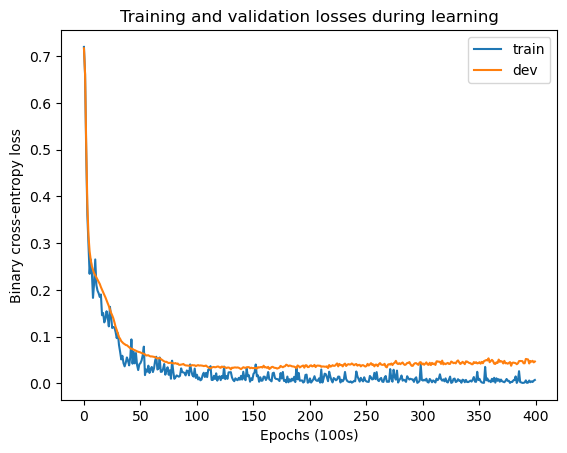

In [356]:
b2 = Deep(units = (2, 4))
b2.train(num_epochs=40000, batch_size=256)
b2.plot()
print("Performance on train set:\n", performance(b2.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(b2.best(Xdev), Ydev))

Creating a model with 215 trainable parameters.
Best performance at epoch 19800
Performance on train set:
 {'falsepos': 27.0, 'falseneg': 25.0, 'accuracy': 0.9968, 'precision': 0.9966, 'recall': 0.9969, 'Fscore': 0.9967}
Performance on dev set:
 {'falsepos': 8.0, 'falseneg': 9.0, 'accuracy': 0.9915, 'precision': 0.9919, 'recall': 0.9909, 'Fscore': 0.9914}


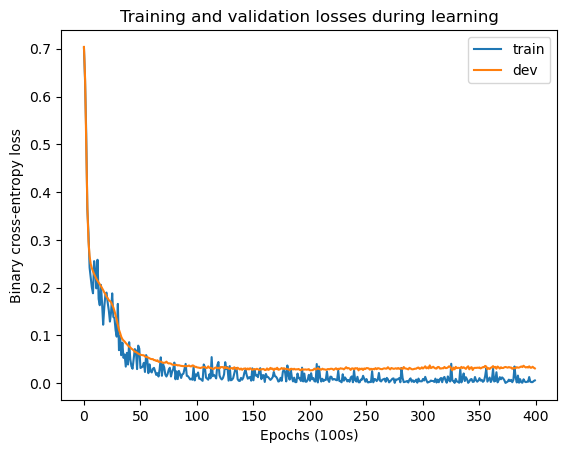

In [357]:
b3 = Deep(units = (2, 8))
b3.train(num_epochs=40000, batch_size=256)
b3.plot()
print("Performance on train set:\n", performance(b3.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(b3.best(Xdev), Ydev))

Creating a model with 389 trainable parameters.
Best performance at epoch 24700
Performance on train set:
 {'falsepos': 10.0, 'falseneg': 0.0, 'accuracy': 0.9994, 'precision': 0.9988, 'recall': 1.0, 'Fscore': 0.9994}
Performance on dev set:
 {'falsepos': 5.0, 'falseneg': 0.0, 'accuracy': 0.9975, 'precision': 0.995, 'recall': 1.0, 'Fscore': 0.9975}


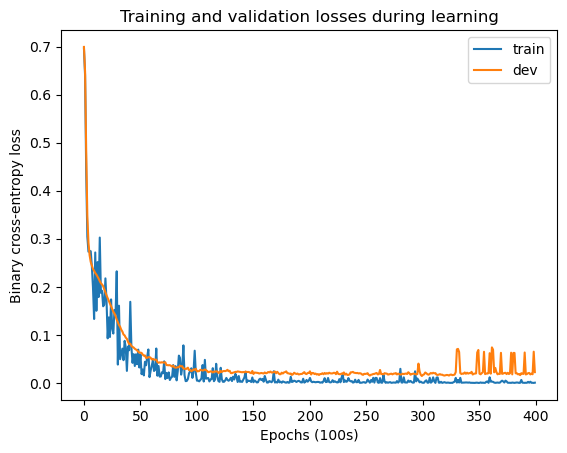

In [359]:
b4 = Deep(units = (4, 4))
b4.train(num_epochs=40000, batch_size=128)
b4.plot()
print("Performance on train set:\n", performance(b4.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(b4.best(Xdev), Ydev))

Creating a model with 611 trainable parameters.
Best performance at epoch 9900
Performance on train set:
 {'falsepos': 0.0, 'falseneg': 0.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'Fscore': 1.0}
Performance on dev set:
 {'falsepos': 7.0, 'falseneg': 0.0, 'accuracy': 0.9965, 'precision': 0.993, 'recall': 1.0, 'Fscore': 0.9965}


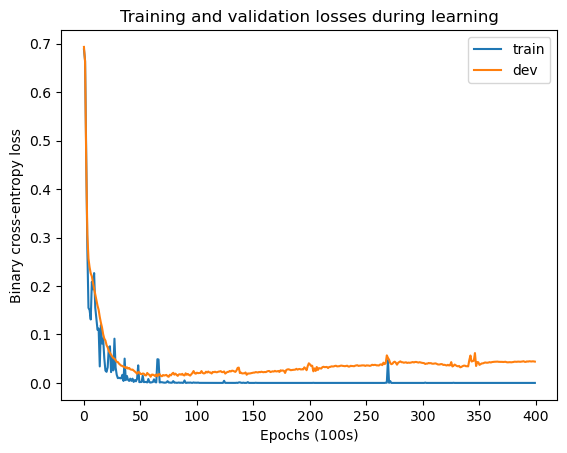

In [360]:
b5 = Deep(units=(6, 8))
b5.train(num_epochs=40000, batch_size=64)
b5.plot()
print("Performance on train set:\n", performance(b5.best(Xtr), Ytr))
print("Performance on dev set:\n", performance(b5.best(Xdev), Ydev))

My general conclusion from this section is that while we have managed to achieve reasonable models with a deeper architecture, there does not appear to be a qualitative shift in their behaviour as compared to the shallow NNs above (Models A). We have had some success in terms of reducing the number of trainable parameters by creating networks with a small number of neurons on the first hiddel layer.

All in all, it has become apparent that the potential for a qualitative shift in the behaviour of our models is only in using a different type of architecture altogether. Below we investigate the use of 1-dimensional convolutions. 

## Model C - 1D Convolution

Convolutional layers are a special type of NN layer which allows for a relatively small matrix (usually called kernel or filter) to interact (be multiplied by) subsets of the input activation for that layer. The filter acts in a manner akin to a sliding window, multiplying specified regions of the input by its weights. A useful visualisation for 2D convolutions (used in image processing and computer vision) is shown [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md).

Convolutional layers result in so called sparse connections between layers - in opposition to dense layers, in which each neuron takes in all activations from the previous, the kernel only interacts with a limited portion of the activations at a time, thus reducing the computational expense. The weights of the kernel are shared throughout the layer, which significantly reduces the overall number of trainable parameters required by the model.

For a task like the present one, in which we aim to classify a text sequence, the use of a 1-dimensional convolution is most appropriate. A kernel will act as a sliding window over the sequence, multiply its weights by the values of the input, and "tell us what it sees" through its own activations. The kernel can be trained to distinguish features like the opening and closing of the same type of bracket, obvious mistakes, paddings inbetween brackets, etc, and feed that information to the next layer which will use it to make a prediction. The benefit is that a well-trained kernel can detect the same features regardless of where in the sequence hey occur.

We will create a series of CNNs, varying mainly the properties of the convolution: the size of the kernel, the stride, and the extra padding.

In [365]:
class CNN:
    def __init__(self, units = 8, 
                 Xtrain = Xtr, Ytrain = Ytr, Xdevel = Xdev, Ydevel = Ydev, 
                 verb = True, ks = 4, ss = 1, pad=0):
        self.train_losses, self.dev_losses = [], []
        self.best_score, self.best_epoch = 0, 0
        self.best = None

        self.model = nn.Sequential(
                # In our API, we measure distances in terms of real characters,
                # but in the NN we need to use the length that a character
                # occupies in the on-hot encoding, hence we multiply by dict_size
                nn.Conv1d(in_channels=1, out_channels=1, 
                          kernel_size=ks*dict_size, stride=ss*dict_size, 
                          padding=pad*dict_size),
                nn.Flatten(),
                nn.Linear((MAX_LEN-ks+2*pad)//ss+1, units),
                nn.ReLU(),
                nn.Linear(units, 1),
                nn.Sigmoid()
                )
        with torch.no_grad():
            # Reshaping X because conv requires a channels dimension
            self.Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, Xtrain.shape[1])
            self.Ytrain = Ytrain
            self.Xdevel = Xdevel.reshape(Xdevel.shape[0], 1, Xdevel.shape[1])
            self.Ydevel = Ydevel
            self.train_size = Xtrain.shape[0]
            self.num_param = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        if verb:
            print(f"Creating a model with {self.num_param} trainable parameters.")

    def __call__(self, X):
        self.out = self.model(X.reshape(X.shape[0], 1, X.shape[1]))
        return self.out

    def train(self, num_epochs = 5000, batch_size = 128, log_freq = 100):
        """
        Performing the requested number of optimisation steps with the 
        appropriate batch size. A record of the train and dev losses is
        bkept at specified intervals, and the model with the best
        F-score is saved for future inference.
        """
        self.model.train = True
        for epoch in range(num_epochs):
            batch_idxs = random.sample(range(self.train_size), batch_size)
            outs = self.model(self.Xtrain[batch_idxs])
            loss = F.binary_cross_entropy(outs, self.Ytrain[batch_idxs])
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % log_freq == 0:
                self.train_losses.append(loss.item())
                with torch.no_grad():
                    dev_pred = self.model(self.Xdevel)
                    dev_loss = F.binary_cross_entropy(dev_pred, self.Ydevel)
                    self.dev_losses.append(dev_loss.item())
                if performance(self.model(self.Xdevel), self.Ydevel)["Fscore"] > self.best_score:
                    self.best_score = performance(self.model(self.Xdevel), self.Ydevel)["Fscore"]
                    self.best = deepcopy(self.model)
                    self.best_epoch = epoch
        
    def plot(self, after = 0):
        """
        Plots a simple graph of the train and dev losses with 
        training. Used to judge the performance of the model:
        bias and variance.
        """
        print(f"Best performance at epoch {self.best_epoch}")
        plt.plot(self.train_losses[after:], label = 'train');
        plt.plot(self.dev_losses[after:], label = 'dev');
        plt.title('Training and validation losses during learning');
        plt.xlabel('Epochs (100s)');
        plt.ylabel('Binary cross-entropy loss');
        plt.legend();

    def print_mislabeled(self, from_train = True, from_dev = True, threshold = 0.5):
        if from_train:
            print("Mislabeled examples from training set:")
            train_pred = [int(out.item() >= threshold) for out in self.best(self.Xtrain)]
            for i in range(len(train_pred)):
                if not train_pred[i] == int(self.Ytrain[i].item()):
                    print(decode(self.Xtrain[i]))
        if from_dev:
            print("Mislabeled examples from development set:")
            dev_pred = [int(out.item() >= threshold) for out in self.best(self.Xdevel)]
            for i in range(len(dev_pred)):
                if not dev_pred[i] == int(self.Ydevel[i].item()):
                    print(decode(self.Xdevel[i]))

Creating a model with 124 trainable parameters.
Best performance at epoch 28000
Performance on train set:
 {'falsepos': 10.0, 'falseneg': 0.0, 'accuracy': 0.9994, 'precision': 0.9988, 'recall': 1.0, 'Fscore': 0.9994}
Performance on dev set:
 {'falsepos': 4.0, 'falseneg': 0.0, 'accuracy': 0.998, 'precision': 0.996, 'recall': 1.0, 'Fscore': 0.998}


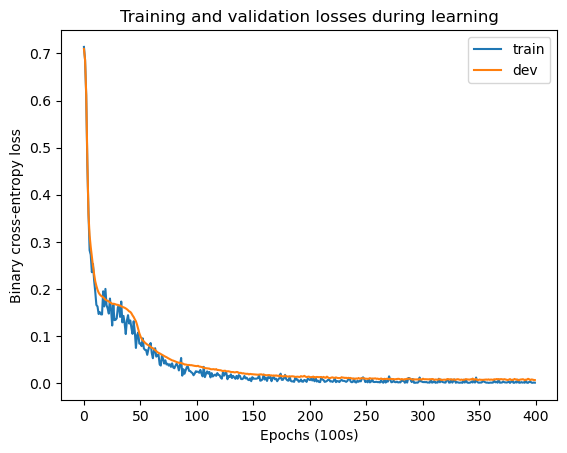

In [371]:
# Kernel takes in 2 characters a time, 
# adds dict_size zeros as a padding on either side of the encoding, 
# and strides 1 character a time
c1 = CNN(ks=2, pad=1, ss=1, units=8)
c1.train(num_epochs=40000, batch_size=1024)
c1.plot()
print("Performance on train set:\n", performance(c1.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c1.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))

We immediately see CNNs allow for a lower number of trainable parameters without compromising performance much. Let's see what happens when we tweak the hyperparameters. Again, the possibilites are endless - so feel free to change things up. 

Creating a model with 176 trainable parameters.
Best performance at epoch 29300
Performance on train set:
 {'falsepos': 1.0, 'falseneg': 0.0, 'accuracy': 0.9999, 'precision': 0.9999, 'recall': 1.0, 'Fscore': 0.9999}
Performance on dev set:
 {'falsepos': 1.0, 'falseneg': 0.0, 'accuracy': 0.9995, 'precision': 0.999, 'recall': 1.0, 'Fscore': 0.9995}


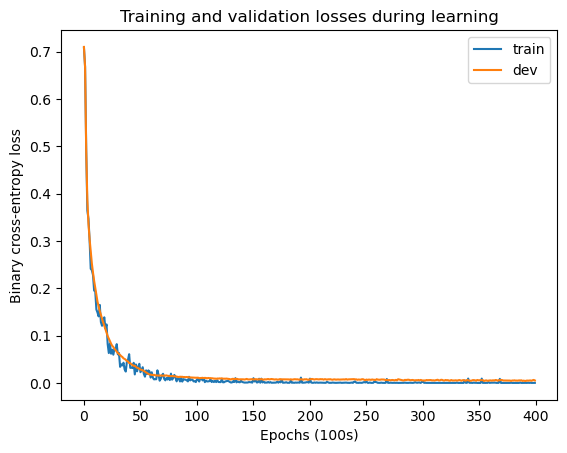

In [372]:
# More dense units
c2 = CNN(ks=2, pad=1, ss=1, units=12)
c2.train(num_epochs=40000, batch_size=512)
c2.plot()
print("Performance on train set:\n", performance(c2.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c2.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))

This is comparable to the smallest shallow network we trained (note we probably got lucky with the randomness in one or both of these). To truly take advantage of convolution, let's see what changing the kernel size and stride does.

Creating a model with 142 trainable parameters.
Best performance at epoch 20700
Performance on train set:
 {'falsepos': 11.0, 'falseneg': 0.0, 'accuracy': 0.9993, 'precision': 0.9986, 'recall': 1.0, 'Fscore': 0.9993}
Performance on dev set:
 {'falsepos': 2.0, 'falseneg': 0.0, 'accuracy': 0.999, 'precision': 0.998, 'recall': 1.0, 'Fscore': 0.999}


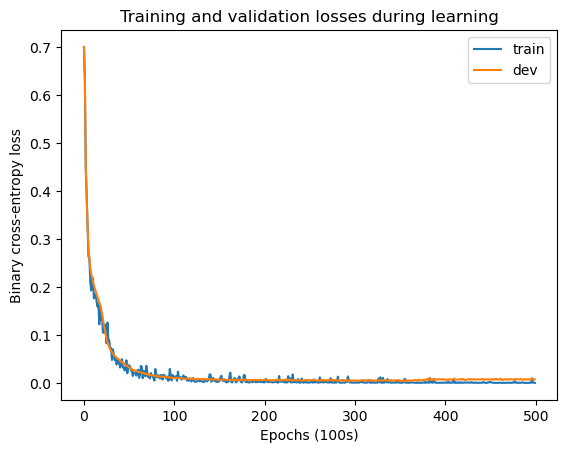

In [373]:
c3 = CNN(ks=4, pad=2, ss=1, units=8)
c3.train(num_epochs=50000, batch_size=512)
c3.plot()
print("Performance on train set:\n", performance(c3.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c3.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))

Creating a model with 110 trainable parameters.
Best performance at epoch 42300
Performance on train set:
 {'falsepos': 3.0, 'falseneg': 0.0, 'accuracy': 0.9998, 'precision': 0.9996, 'recall': 1.0, 'Fscore': 0.9998}
Performance on dev set:
 {'falsepos': 2.0, 'falseneg': 0.0, 'accuracy': 0.999, 'precision': 0.998, 'recall': 1.0, 'Fscore': 0.999}


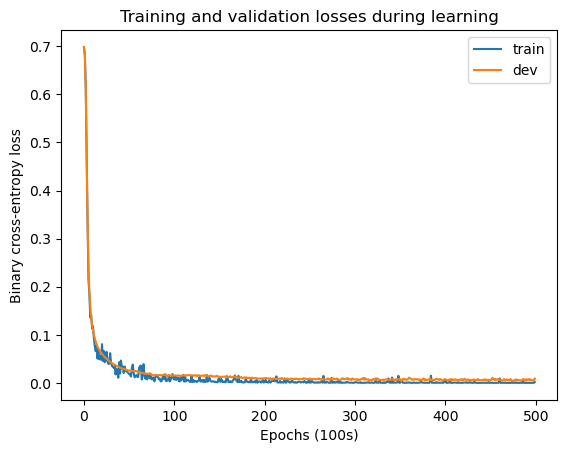

In [374]:
# Let's check out increasing stride - ie skippin over some characters

c4 = CNN(ks=4, pad=3, ss=2, units=8)
c4.train(num_epochs=50000, batch_size=512)
c4.plot()
print("Performance on train set:\n", performance(c4.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c4.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))

That one looks pretty good! Let's push our luck a bit.

Creating a model with 128 trainable parameters.
Best performance at epoch 30500
Performance on train set:
 {'falsepos': 2.0, 'falseneg': 0.0, 'accuracy': 0.9999, 'precision': 0.9997, 'recall': 1.0, 'Fscore': 0.9999}
Performance on dev set:
 {'falsepos': 3.0, 'falseneg': 0.0, 'accuracy': 0.9985, 'precision': 0.997, 'recall': 1.0, 'Fscore': 0.9985}


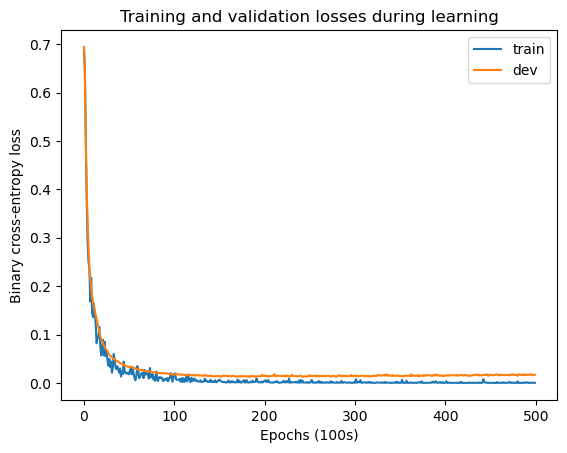

In [375]:
c5 = CNN(ks=6, pad=4, ss=2, units=8)
c5.train(num_epochs=50000, batch_size=512)
c5.plot()
print("Performance on train set:\n", performance(c5.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c5.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))

Creating a model with 96 trainable parameters.
Best performance at epoch 24700
Performance on train set:
 {'falsepos': 595.0, 'falseneg': 0.0, 'accuracy': 0.963, 'precision': 0.9307, 'recall': 1.0, 'Fscore': 0.9641}
Performance on dev set:
 {'falsepos': 80.0, 'falseneg': 0.0, 'accuracy': 0.9602, 'precision': 0.925, 'recall': 1.0, 'Fscore': 0.9611}


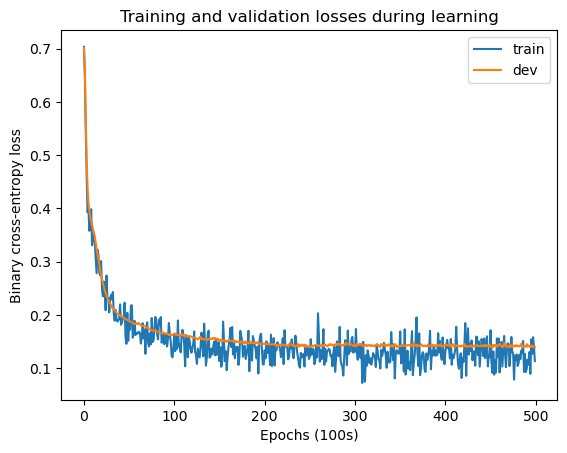

In [377]:
c6 = CNN(ks=6, pad=0, ss=2, units=8)
c6.train(num_epochs=50000, batch_size=512)
c6.plot()
print("Performance on train set:\n", performance(c6.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c6.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))

No padding saves us parameters but appears to be a bad influence on performance.

Creating a model with 104 trainable parameters.
Best performance at epoch 20000
Performance on train set:
 {'falsepos': 18.0, 'falseneg': 0.0, 'accuracy': 0.9989, 'precision': 0.9978, 'recall': 1.0, 'Fscore': 0.9989}
Performance on dev set:
 {'falsepos': 1.0, 'falseneg': 0.0, 'accuracy': 0.9995, 'precision': 0.999, 'recall': 1.0, 'Fscore': 0.9995}


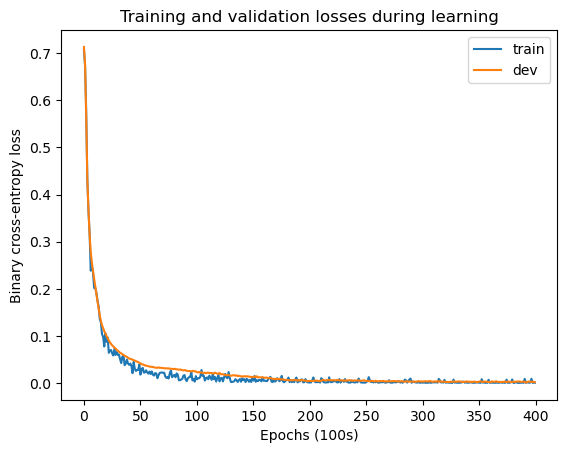

In [380]:
c7 = CNN(ks=6, pad=3, ss=3, units=8)
c7.train(num_epochs=40000, batch_size=1024)
c7.plot()
print("Performance on train set:\n", performance(c7.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c7.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))

Creating a model with 116 trainable parameters.
Best performance at epoch 33200
Performance on train set:
 {'falsepos': 13.0, 'falseneg': 0.0, 'accuracy': 0.9992, 'precision': 0.9984, 'recall': 1.0, 'Fscore': 0.9992}
Performance on dev set:
 {'falsepos': 5.0, 'falseneg': 0.0, 'accuracy': 0.9975, 'precision': 0.995, 'recall': 1.0, 'Fscore': 0.9975}


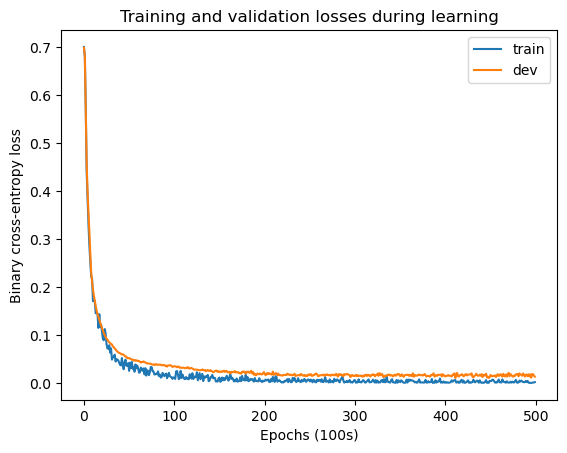

In [384]:
c8 = CNN(ks=6, pad=2, ss=3, units=12)
c8.train(num_epochs=50000, batch_size=1024)
c8.plot()
print("Performance on train set:\n", performance(c8.best(Xtr.reshape(Xtr.shape[0], 1, Xtr.shape[1])), Ytr))
print("Performance on dev set:\n", performance(c8.best(Xdev.reshape(Xdev.shape[0], 1, Xdev.shape[1])), Ydev))